In [14]:
import warnings
warnings.filterwarnings('ignore')

In [15]:
# import packages
import numpy as np
import pylab as py
import pdb
import matplotlib.pyplot as plt
import math

# import spisea packages
from spisea import synthetic, evolution, atmospheres, reddening, ifmr
from spisea.imf import imf, multiplicity

# import nbody6tools reader to read data
from nbody6tools import Reader

# import nbody62spisea to retrieve star ages
from nbody62spisea import converter

# colormap stuff for gradient plotting
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

In [16]:
# Define bounding box limits
color_min = 0.90
color_max = 1.00
mag_min = 11
mag_max = 15
color_step = 0.01

In [17]:
# Define diagram axis limits
xlim_min = 0.5
xlim_max = 1.25
ylim_min = 8
ylim_max = 19

In [18]:
# Function to measure spread in a CMD with resolved binaries
def measure_spread(stars, companions, color_min, color_max, mag_min, mag_max, color_step):
    bin_std_deviations = []

    # Iterate over color bins
    for color_index in np.arange(color_min, color_max, color_step):
        mag_bin = []

        # Iterate over stars within the current color bin
        for star in stars:
            if star is None:
                continue
            if color_index < star[3] - star[4] < color_index + color_step and mag_min < star[4] < mag_max:
                mag_bin.append(star[4])

        # Iterate over companions within the current color bin
        for companion in companions:
            if companion is None:
                continue
            if color_index < companion[3] - companion[4] < color_index + color_step and mag_min < companion[4] < mag_max:
                mag_bin.append(companion[4])

        bin_std = np.std(mag_bin)
        bin_std_deviations.append(bin_std)

    # Compute the average standard deviation
    average_std = np.mean(bin_std_deviations)
    return average_std

In [19]:
# Function to measure spread in a CMD with unresolved binaries
def measure_spread_unresolved(stars, unresolved_binaries, color_min, color_max, mag_min, mag_max, color_step):
    bin_std_deviations = []

    # Iterate over color bins
    for color_index in np.arange(color_min, color_max, color_step):
        mag_bin = []

        # Iterate over stars within the current color bin
        for star in stars:
            if star is None:
                continue
            if color_index < star[3] - star[4] < color_index + color_step and mag_min < star[4] < mag_max:
                mag_bin.append(star[4])

        # Iterate over unresolved binaries within the current color bin
        for binary in unresolved_binaries:
            if binary is None:
                continue
            if color_index < binary[0] - binary[1] < color_index + color_step and mag_min < binary[1] < mag_max:
                mag_bin.append(binary[1])

        bin_std = np.std(mag_bin)
        bin_std_deviations.append(bin_std)

    # Compute the average standard deviation
    average_std = np.mean(bin_std_deviations)
    return average_std

In [20]:
# define isochrone parameters
AKs = 0
dist = 410
evo_model = evolution.Baraffe15()
atm_func = atmospheres.get_merged_atmosphere
red_law = reddening.RedLawHosek18b()
filt_list = ['jwst,F115W', 'jwst,F200W']
filters = ['m_jwst_F115W', 'm_jwst_F200W']
iso_dir = 'isochrones/'
metallicity = 0

Cluster Time: 0.5 Myr
Average Standard Deviation (Resolved): nan
Average Standard Deviation (Unresolved): nan

Cluster Time: 1 Myr
Average Standard Deviation (Resolved): 0.05
Average Standard Deviation (Unresolved): 0.21

Cluster Time: 2 Myr
Average Standard Deviation (Resolved): 0.21
Average Standard Deviation (Unresolved): 0.32

Cluster Time: 5 Myr
Average Standard Deviation (Resolved): 0.19
Average Standard Deviation (Unresolved): 0.29

Cluster Time: 10 Myr
Average Standard Deviation (Resolved): 0.54
Average Standard Deviation (Unresolved): 0.56

Cluster Time: 15 Myr
Average Standard Deviation (Resolved): 0.50
Average Standard Deviation (Unresolved): 0.55

Cluster Time: 20 Myr
Average Standard Deviation (Resolved): 0.38
Average Standard Deviation (Unresolved): 0.47



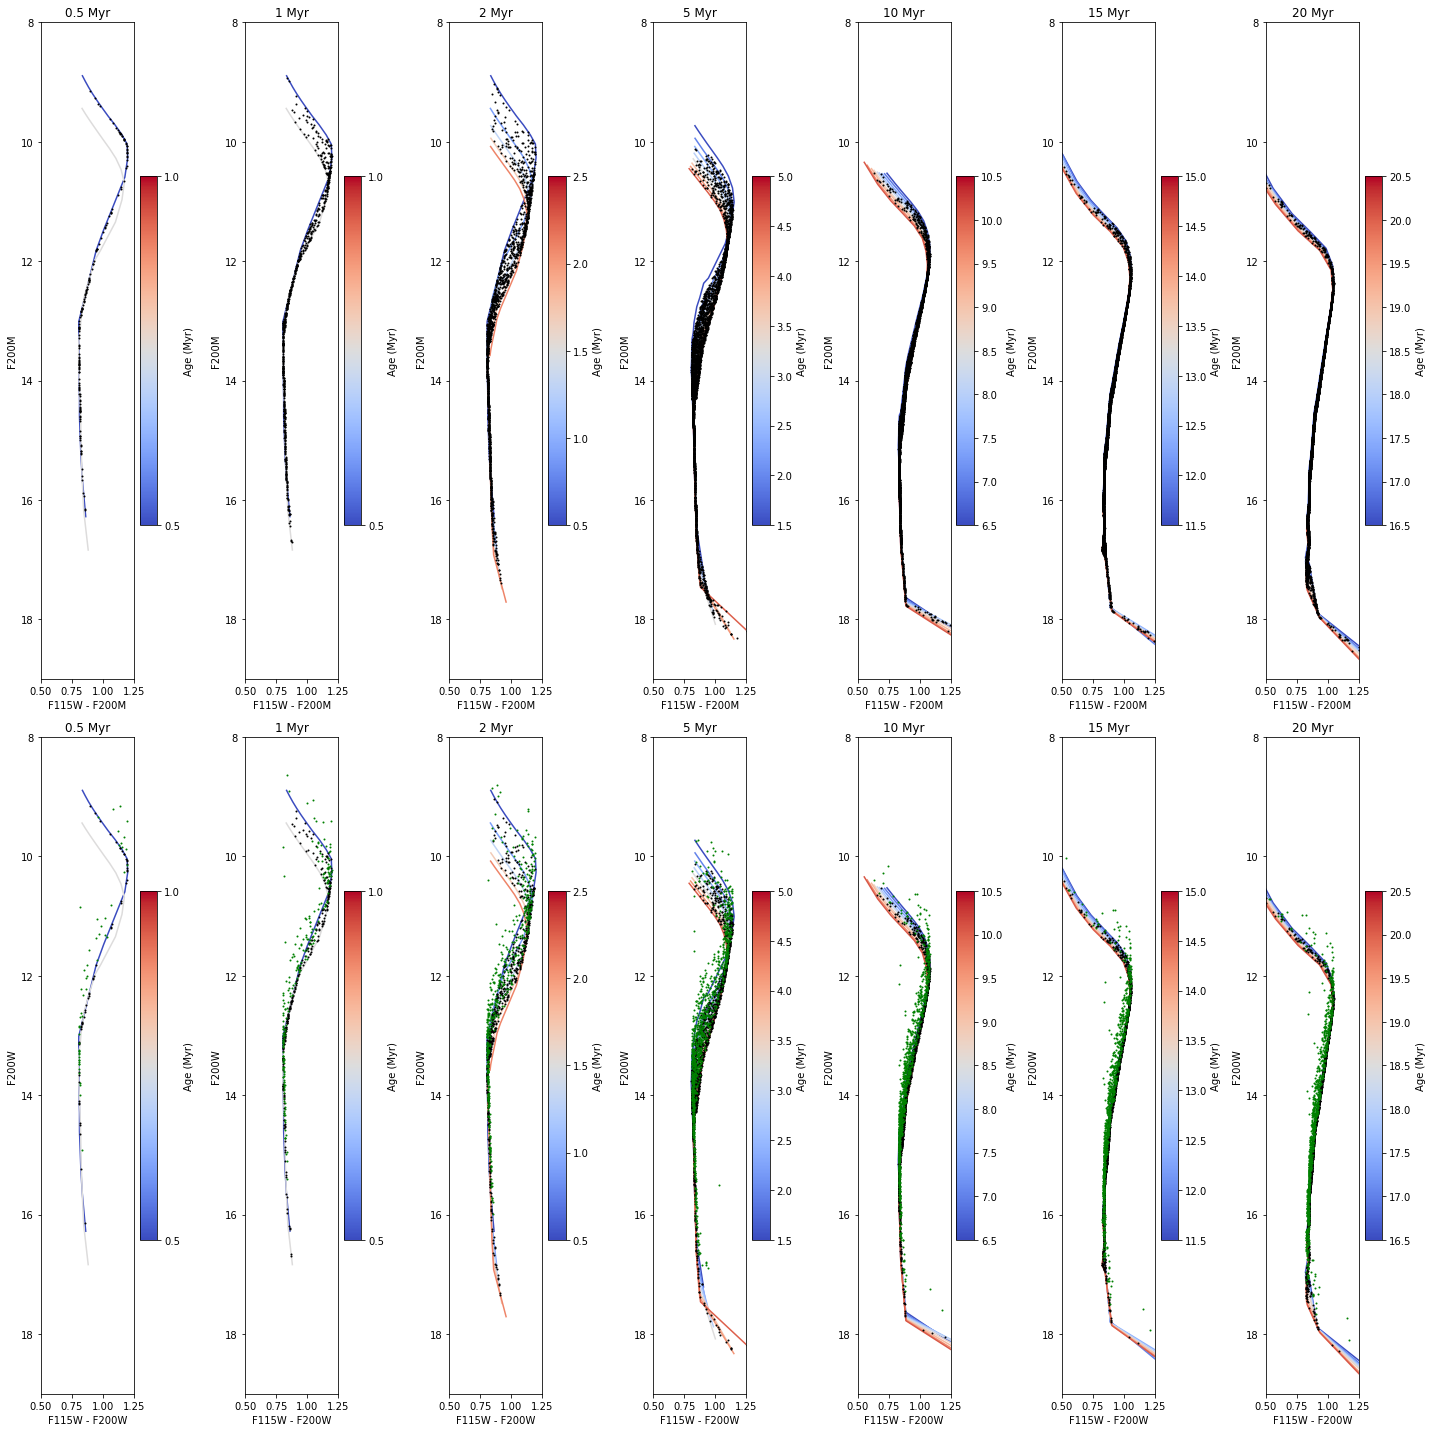

In [21]:
# read nbody data
path_to_data = '../../../../../../../storage/jfarias/Data/Orion/newbinaries/M3000sigma1.0/sfeff001_00/'

fig, axes = py.subplots(figsize=(20, 20))

cluster_times = [0.5, 1, 2, 5, 10, 15, 20]

for t in range(len(cluster_times)):
    # =============== READ NBODY SNAPSHOT =============================
    snapshot = Reader.read_snapshot(path_to_data, time = cluster_times[t])

    # convert snapshot values from nbody units to astrophysical, extract masses
    snapshot.to_physical()
    cluster_table = converter.to_spicea_table(snapshot)
    
    # =============== READ MASS AND AGE ==================================
    masses = cluster_table['mass']
    level_ages = cluster_table['age']

    # convert level ages from Myr to yr
    for i in range(len(level_ages)):
        level_ages[i] = level_ages[i] * 1e6

    # convert log ages from log(Myr) to log(yr)
    log_ages = np.log10(level_ages)
    
    # =============== READ COMPANION STARS ================================
    # find index of first binary, create array of companion masses
    first_binary = 0
    for i in range(len(cluster_table)):
        if cluster_table['isMultiple'][i] == 1.0:
            first_binary = i
            break

    compMasses = []
    for i in range(len(cluster_table)):
        if cluster_table['isMultiple'][i] == 1.0:
            compMasses.append(cluster_table['compMass'][i][0])
            
    # ============== CREATE ISOCHRONE AGE ARRAY ============================
    increment = 0.5e6

    if min(level_ages) < 0.5e6:
        start = 0.5e6
    else:
        start = (min(level_ages) // increment) * increment

    end = (max(level_ages) // increment) * increment + 2 * increment

    # Create age arrays
    level_age_arr = np.arange(start, end, increment)
    log_age_arr = np.log10(level_age_arr)
    
    # ============= CREATE ISOCHRONES =======================================
    instances = np.empty(len(log_age_arr), dtype=object)

    for i in range(len(log_age_arr)):
        my_iso = synthetic.IsochronePhot(log_age_arr[i], AKs, dist, metallicity=metallicity,
                            evo_model=evo_model, atm_func=atm_func,
                            red_law=red_law, filters=filt_list,
                                iso_dir=iso_dir)
        instances[i] = my_iso
        
    # ============= INTERPOLATE STARS =======================================
    import sys
    sys.path.append('/scratch/wyz5rge/synthetic-hr/')
    import interpolator as interpolator

    level_ages_myr = level_ages / 1e6
    # print(level_ages_myr)

    # create array of stars
    stars = np.empty(len(cluster_table), dtype=object)

    # perform interpolation for each star
    for i in range(len(stars)):
        stars[i] = interpolator.interpolate(level_ages_myr[i], masses[i], instances, log_age_arr, filters)
    
    # convert luminosity values to solar luminosities
    watts_to_lsun = 1.0 / (3.846e26)

    for i in range(len(stars)):
        if stars[i] is None:
            continue
        stars[i][0] = stars[i][0] * watts_to_lsun
        
    # perform interpolation on companion stars
    companions = np.empty(len(compMasses), dtype=object)

    for i in range(len(companions)):
        if stars[i + first_binary] is None:
            continue
        companions[i] = interpolator.interpolate(level_ages_myr[i + first_binary], compMasses[i], instances, log_age_arr, filters)

    for i in range(len(companions)):
        if companions[i] is None:
            continue
        companions[i][0] = companions[i][0] * watts_to_lsun
        
    # ============ PLOT RESOLVED BINARIES ===========================

    py.subplot(2, len(cluster_times), t + 1)

    # plot isochrones
    # Define a colormap
    cmap = plt.get_cmap('coolwarm')  # You can choose any colormap you prefer

    for i in range(len(log_age_arr)):
        color = cmap(i / (len(log_age_arr)))  # Assign color based on index and colormap
        py.plot(instances[i].points[filters[0]] - instances[i].points[filters[1]], 
                instances[i].points[filters[1]], color=color, label='')

    # plot primaries
    for i in range(len(stars)):
        if stars[i] is None:
            continue
        py.plot(stars[i][3] - stars[i][4], stars[i][4], marker='o', markersize=1, color='k')

    # plot companions
    for i in range(len(companions)):
        if companions[i] is None:
            continue
        py.plot(companions[i][3] - companions[i][4], companions[i][4], marker='o', markersize=1, color='k')

    py.xlim(xlim_min, xlim_max)
    py.ylim(ylim_min, ylim_max)
    py.xlabel('F115W - F200M')
    py.ylabel('F200M')
    py.gca().invert_yaxis()
    py.title(str(cluster_times[t]) + ' Myr')
    
    # Create colorbar legend
    norm = Normalize(vmin=min(level_age_arr), vmax=max(level_age_arr))
    sm = ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])
    cbar = plt.colorbar(sm)
    cbar.set_label('Age (Myr)')
    cbar.set_ticks(level_age_arr)
    cbar.set_ticklabels([f'{age/1e6:.1f}' for age in level_age_arr])
    
    # Measure spread for resolved binaries
    avg_std_resolved = measure_spread(stars, companions, color_min, color_max, mag_min, mag_max, color_step)
    
    # =========== CALCULATE UNRESOLVED BINARIES ===================
    unresolved_binaries = np.empty(len(companions), dtype=object)

    for i in range(len(companions)):
        if stars[i + first_binary] is None or companions[i] is None:
            continue

        flux11 = np.power(10, stars[i + first_binary][3] / -2.5) * 3.93e-10
        flux21 = np.power(10, companions[i][3] / -2.5) * 3.93e-10
        mag1 = -2.5 * np.log10((flux11 + flux21) / 3.93e-10)

        flux12 = np.power(10, stars[i + first_binary][4] / -2.5) * 5.74e-11
        flux22 = np.power(10, companions[i][4] / -2.5) * 5.74e-11
        mag2 = -2.5 * np.log10((flux12 + flux22) / 5.744e-11)

        unresolved_binaries[i] = [mag1, mag2]
    
    # =========== PLOT UNRESOLVED BINARIES ========================
    
    py.subplot(2, len(cluster_times), t + len(cluster_times) + 1)
    
    for i in range(len(log_age_arr)):
        color = cmap(i / (len(log_age_arr)))  # Assign color based on index and colormap
        py.plot(instances[i].points[filters[0]] - instances[i].points[filters[1]], 
                instances[i].points[filters[1]], color=color, label='')

    # plot single stars first
    for i in range(0, first_binary):
        if stars[i] is None:
            continue
        py.plot(stars[i][3] - stars[i][4], stars[i][4], marker='o', markersize=1, color='k')

    # plot unresolve binaries
    for i in range(len(unresolved_binaries)):
        if unresolved_binaries[i] is None:
            continue
        py.plot(stars[first_binary + i][3] - stars[first_binary + i][4], 
                unresolved_binaries[i][1], marker='o', markersize=1, color='green')

    py.xlim(xlim_min, xlim_max)
    py.ylim(ylim_min, ylim_max)
    py.xlabel('F115W - F200W')
    py.ylabel('F200W')
    py.gca().invert_yaxis()
    py.title(str(cluster_times[t]) + ' Myr')
    
    # Create colorbar legend
    norm = Normalize(vmin=min(level_age_arr), vmax=max(level_age_arr))
    sm = ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])
    cbar = plt.colorbar(sm)
    cbar.set_label('Age (Myr)')
    cbar.set_ticks(level_age_arr)
    cbar.set_ticklabels([f'{age/1e6:.1f}' for age in level_age_arr])
    
    # Measure spread for unresolved binaries
    avg_std_unresolved = measure_spread_unresolved(stars[:first_binary], unresolved_binaries, color_min, color_max, mag_min, mag_max, color_step)
    
    # ========== PRINT SPREAD RESULTS ===========================
    print(f"Cluster Time: {cluster_times[t]} Myr")
    print(f"Average Standard Deviation (Resolved): {avg_std_resolved:.2f}")
    print(f"Average Standard Deviation (Unresolved): {avg_std_unresolved:.2f}")
    print()
    
plt.tight_layout()
plt.show()

Cluster Time: 0.5 Myr
Average Standard Deviation (Resolved): nan
Average Standard Deviation (Unresolved): nan

Cluster Time: 1 Myr
Average Standard Deviation (Resolved): 0.04
Average Standard Deviation (Unresolved): 0.22

Cluster Time: 2 Myr
Average Standard Deviation (Resolved): 0.16
Average Standard Deviation (Unresolved): 0.29

Cluster Time: 5 Myr
Average Standard Deviation (Resolved): 0.07
Average Standard Deviation (Unresolved): 0.29

Cluster Time: 10 Myr
Average Standard Deviation (Resolved): 0.46
Average Standard Deviation (Unresolved): 0.54

Cluster Time: 15 Myr
Average Standard Deviation (Resolved): 0.42
Average Standard Deviation (Unresolved): 0.50

Cluster Time: 20 Myr
Average Standard Deviation (Resolved): 0.42
Average Standard Deviation (Unresolved): 0.50



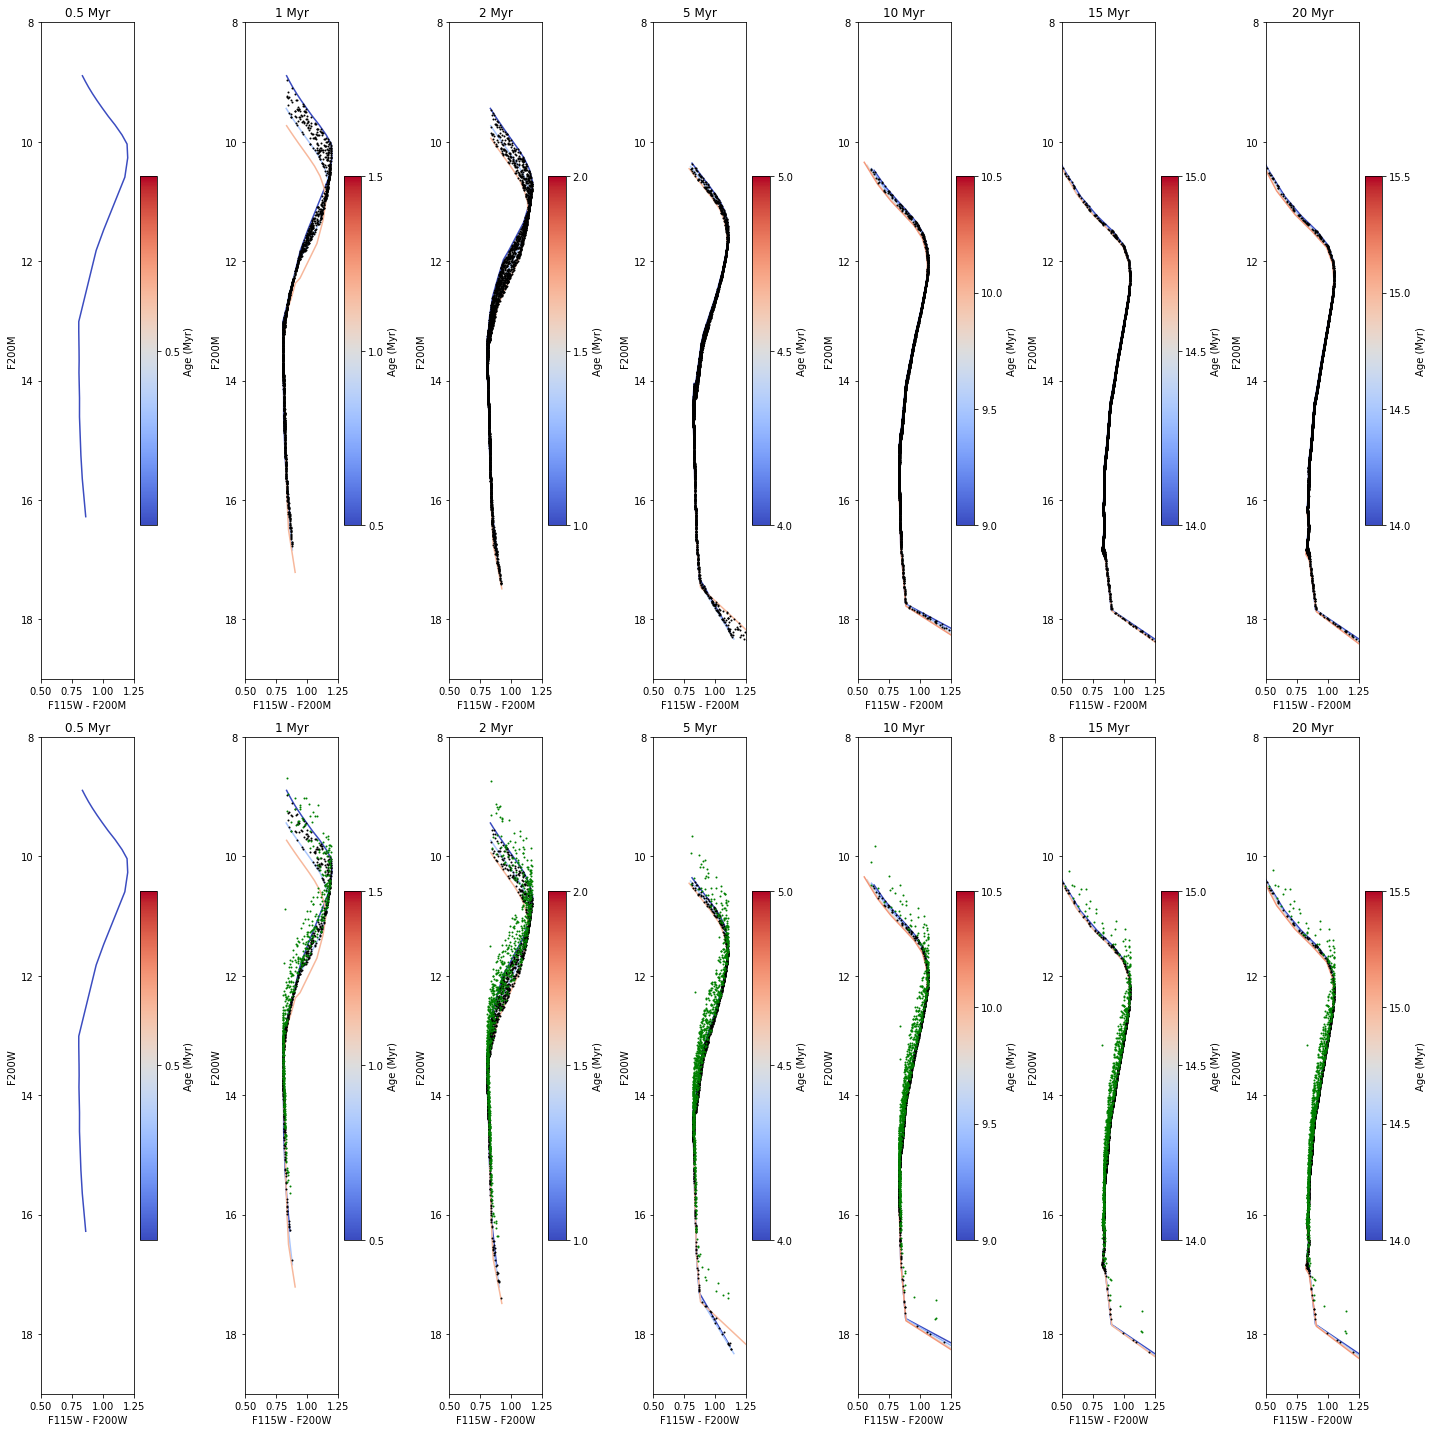

In [22]:
# read nbody data
path_to_data = '../../../../../../../storage/jfarias/Data/Orion/newbinaries/M3000sigma1.0/sfeff003_00/'

fig, axes = py.subplots(figsize=(20, 20))

cluster_times = [0.5, 1, 2, 5, 10, 15, 20]

for t in range(len(cluster_times)):
    # =============== READ NBODY SNAPSHOT =============================
    snapshot = Reader.read_snapshot(path_to_data, time = cluster_times[t])

    # convert snapshot values from nbody units to astrophysical, extract masses
    snapshot.to_physical()
    cluster_table = converter.to_spicea_table(snapshot)
    
    # =============== READ MASS AND AGE ==================================
    masses = cluster_table['mass']
    level_ages = cluster_table['age']

    # convert level ages from Myr to yr
    for i in range(len(level_ages)):
        level_ages[i] = level_ages[i] * 1e6

    # convert log ages from log(Myr) to log(yr)
    log_ages = np.log10(level_ages)
    
    # =============== READ COMPANION STARS ================================
    # find index of first binary, create array of companion masses
    first_binary = 0
    for i in range(len(cluster_table)):
        if cluster_table['isMultiple'][i] == 1.0:
            first_binary = i
            break

    compMasses = []
    for i in range(len(cluster_table)):
        if cluster_table['isMultiple'][i] == 1.0:
            compMasses.append(cluster_table['compMass'][i][0])
            
    # ============== CREATE ISOCHRONE AGE ARRAY ============================
    increment = 0.5e6

    if min(level_ages) < 0.5e6:
        start = 0.5e6
    else:
        start = (min(level_ages) // increment) * increment

    end = (max(level_ages) // increment) * increment + 2 * increment

    # Create age arrays
    level_age_arr = np.arange(start, end, increment)
    log_age_arr = np.log10(level_age_arr)
    
    # ============= CREATE ISOCHRONES =======================================
    instances = np.empty(len(log_age_arr), dtype=object)

    for i in range(len(log_age_arr)):
        my_iso = synthetic.IsochronePhot(log_age_arr[i], AKs, dist, metallicity=metallicity,
                            evo_model=evo_model, atm_func=atm_func,
                            red_law=red_law, filters=filt_list,
                                iso_dir=iso_dir)
        instances[i] = my_iso
        
    # ============= INTERPOLATE STARS =======================================
    import sys
    sys.path.append('/scratch/wyz5rge/synthetic-hr/')
    import interpolator as interpolator

    level_ages_myr = level_ages / 1e6
    # print(level_ages_myr)

    # create array of stars
    stars = np.empty(len(cluster_table), dtype=object)

    # perform interpolation for each star
    for i in range(len(stars)):
        stars[i] = interpolator.interpolate(level_ages_myr[i], masses[i], instances, log_age_arr, filters)
    
    # convert luminosity values to solar luminosities
    watts_to_lsun = 1.0 / (3.846e26)

    for i in range(len(stars)):
        if stars[i] is None:
            continue
        stars[i][0] = stars[i][0] * watts_to_lsun
        
    # perform interpolation on companion stars
    companions = np.empty(len(compMasses), dtype=object)

    for i in range(len(companions)):
        if stars[i + first_binary] is None:
            continue
        companions[i] = interpolator.interpolate(level_ages_myr[i + first_binary], compMasses[i], instances, log_age_arr, filters)

    for i in range(len(companions)):
        if companions[i] is None:
            continue
        companions[i][0] = companions[i][0] * watts_to_lsun
        
    # ============ PLOT RESOLVED BINARIES ===========================

    py.subplot(2, len(cluster_times), t + 1)

    # plot isochrones
    # Define a colormap
    cmap = plt.get_cmap('coolwarm')  # You can choose any colormap you prefer

    for i in range(len(log_age_arr)):
        color = cmap(i / (len(log_age_arr)))  # Assign color based on index and colormap
        py.plot(instances[i].points[filters[0]] - instances[i].points[filters[1]], 
                instances[i].points[filters[1]], color=color, label='')

    # plot primaries
    for i in range(len(stars)):
        if stars[i] is None:
            continue
        py.plot(stars[i][3] - stars[i][4], stars[i][4], marker='o', markersize=1, color='k')

    # plot companions
    for i in range(len(companions)):
        if companions[i] is None:
            continue
        py.plot(companions[i][3] - companions[i][4], companions[i][4], marker='o', markersize=1, color='k')

    py.xlim(xlim_min, xlim_max)
    py.ylim(ylim_min, ylim_max)
    py.xlabel('F115W - F200M')
    py.ylabel('F200M')
    py.gca().invert_yaxis()
    py.title(str(cluster_times[t]) + ' Myr')
    
    # Create colorbar legend
    norm = Normalize(vmin=min(level_age_arr), vmax=max(level_age_arr))
    sm = ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])
    cbar = plt.colorbar(sm)
    cbar.set_label('Age (Myr)')
    cbar.set_ticks(level_age_arr)
    cbar.set_ticklabels([f'{age/1e6:.1f}' for age in level_age_arr])
    
    # Measure spread for resolved binaries
    avg_std_resolved = measure_spread(stars, companions, color_min, color_max, mag_min, mag_max, color_step)
    
    # =========== CALCULATE UNRESOLVED BINARIES ===================
    unresolved_binaries = np.empty(len(companions), dtype=object)

    for i in range(len(companions)):
        if stars[i + first_binary] is None or companions[i] is None:
            continue

        flux11 = np.power(10, stars[i + first_binary][3] / -2.5) * 3.93e-10
        flux21 = np.power(10, companions[i][3] / -2.5) * 3.93e-10
        mag1 = -2.5 * np.log10((flux11 + flux21) / 3.93e-10)

        flux12 = np.power(10, stars[i + first_binary][4] / -2.5) * 5.74e-11
        flux22 = np.power(10, companions[i][4] / -2.5) * 5.74e-11
        mag2 = -2.5 * np.log10((flux12 + flux22) / 5.744e-11)

        unresolved_binaries[i] = [mag1, mag2]
    
    # =========== PLOT UNRESOLVED BINARIES ========================
    
    py.subplot(2, len(cluster_times), t + len(cluster_times) + 1)
    
    for i in range(len(log_age_arr)):
        color = cmap(i / (len(log_age_arr)))  # Assign color based on index and colormap
        py.plot(instances[i].points[filters[0]] - instances[i].points[filters[1]], 
                instances[i].points[filters[1]], color=color, label='')

    # plot single stars first
    for i in range(0, first_binary):
        if stars[i] is None:
            continue
        py.plot(stars[i][3] - stars[i][4], stars[i][4], marker='o', markersize=1, color='k')

    # plot unresolve binaries
    for i in range(len(unresolved_binaries)):
        if unresolved_binaries[i] is None:
            continue
        py.plot(stars[first_binary + i][3] - stars[first_binary + i][4], 
                unresolved_binaries[i][1], marker='o', markersize=1, color='green')

    py.xlim(xlim_min, xlim_max)
    py.ylim(ylim_min, ylim_max)
    py.xlabel('F115W - F200W')
    py.ylabel('F200W')
    py.gca().invert_yaxis()
    py.title(str(cluster_times[t]) + ' Myr')
    
    # Create colorbar legend
    norm = Normalize(vmin=min(level_age_arr), vmax=max(level_age_arr))
    sm = ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])
    cbar = plt.colorbar(sm)
    cbar.set_label('Age (Myr)')
    cbar.set_ticks(level_age_arr)
    cbar.set_ticklabels([f'{age/1e6:.1f}' for age in level_age_arr])
    
    # Measure spread for unresolved binaries
    avg_std_unresolved = measure_spread_unresolved(stars[:first_binary], unresolved_binaries, color_min, color_max, mag_min, mag_max, color_step)
    
    # ========== PRINT SPREAD RESULTS ===========================
    print(f"Cluster Time: {cluster_times[t]} Myr")
    print(f"Average Standard Deviation (Resolved): {avg_std_resolved:.2f}")
    print(f"Average Standard Deviation (Unresolved): {avg_std_unresolved:.2f}")
    print()
    
plt.tight_layout()
plt.show()

Cluster Time: 0.5 Myr
Average Standard Deviation (Resolved): nan
Average Standard Deviation (Unresolved): nan

Cluster Time: 1 Myr
Average Standard Deviation (Resolved): 0.03
Average Standard Deviation (Unresolved): 0.24

Cluster Time: 2 Myr
Average Standard Deviation (Resolved): 0.04
Average Standard Deviation (Unresolved): 0.27

Cluster Time: 5 Myr
Average Standard Deviation (Resolved): 0.05
Average Standard Deviation (Unresolved): 0.29

Cluster Time: 10 Myr
Average Standard Deviation (Resolved): 0.46
Average Standard Deviation (Unresolved): 0.54

Cluster Time: 15 Myr
Average Standard Deviation (Resolved): 0.40
Average Standard Deviation (Unresolved): 0.49

Cluster Time: 20 Myr
Average Standard Deviation (Resolved): 0.34
Average Standard Deviation (Unresolved): 0.46



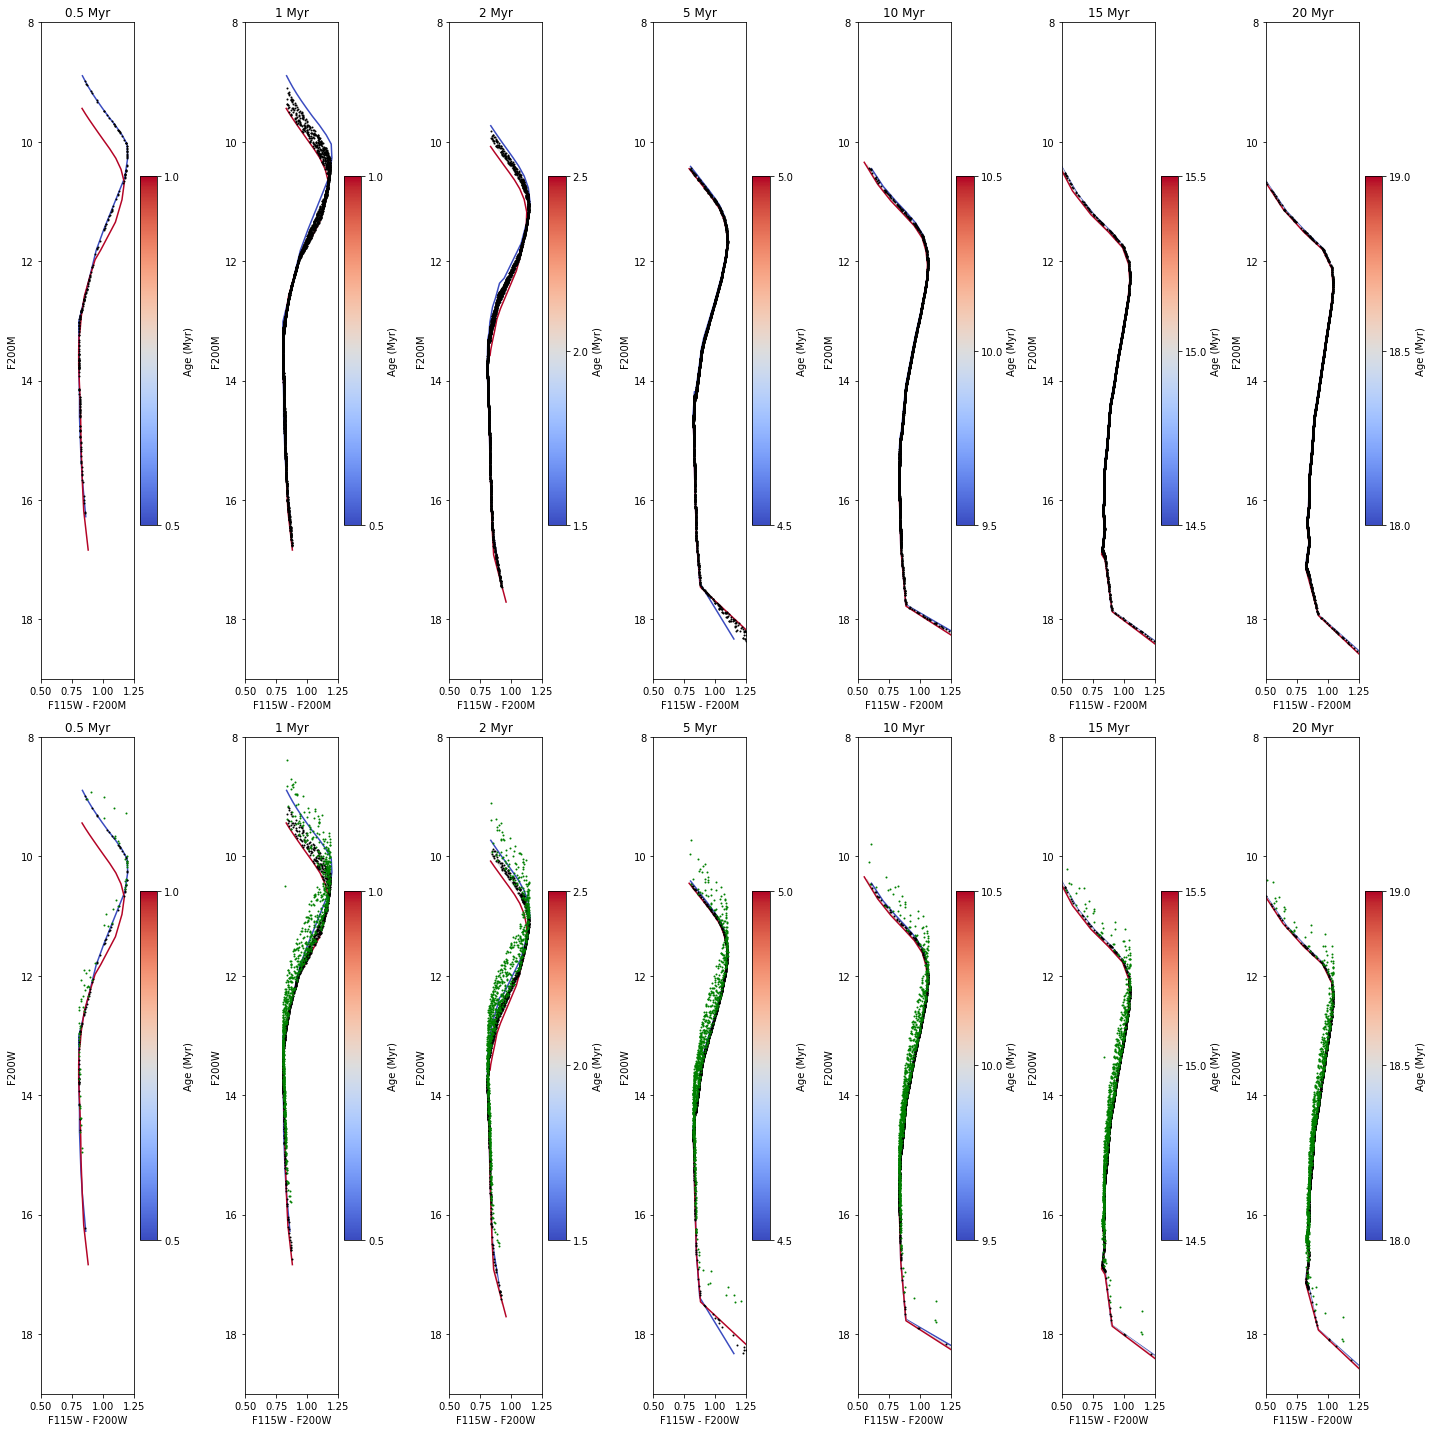

In [23]:
# read nbody data
path_to_data = '../../../../../../../storage/jfarias/Data/Orion/newbinaries/M3000sigma1.0/sfeff010_00/'

fig, axes = py.subplots(figsize=(20, 20))

cluster_times = [0.5, 1, 2, 5, 10, 15, 20]

for t in range(len(cluster_times)):
    # =============== READ NBODY SNAPSHOT =============================
    snapshot = Reader.read_snapshot(path_to_data, time = cluster_times[t])

    # convert snapshot values from nbody units to astrophysical, extract masses
    snapshot.to_physical()
    cluster_table = converter.to_spicea_table(snapshot)
    
    # =============== READ MASS AND AGE ==================================
    masses = cluster_table['mass']
    level_ages = cluster_table['age']

    # convert level ages from Myr to yr
    for i in range(len(level_ages)):
        level_ages[i] = level_ages[i] * 1e6

    # convert log ages from log(Myr) to log(yr)
    log_ages = np.log10(level_ages)
    
    # =============== READ COMPANION STARS ================================
    # find index of first binary, create array of companion masses
    first_binary = 0
    for i in range(len(cluster_table)):
        if cluster_table['isMultiple'][i] == 1.0:
            first_binary = i
            break

    compMasses = []
    for i in range(len(cluster_table)):
        if cluster_table['isMultiple'][i] == 1.0:
            compMasses.append(cluster_table['compMass'][i][0])
            
    # ============== CREATE ISOCHRONE AGE ARRAY ============================
    increment = 0.5e6

    if min(level_ages) < 0.5e6:
        start = 0.5e6
    else:
        start = (min(level_ages) // increment) * increment

    end = (max(level_ages) // increment) * increment + 2 * increment

    # Create age arrays
    level_age_arr = np.arange(start, end, increment)
    log_age_arr = np.log10(level_age_arr)
    
    # ============= CREATE ISOCHRONES =======================================
    instances = np.empty(len(log_age_arr), dtype=object)

    for i in range(len(log_age_arr)):
        my_iso = synthetic.IsochronePhot(log_age_arr[i], AKs, dist, metallicity=metallicity,
                            evo_model=evo_model, atm_func=atm_func,
                            red_law=red_law, filters=filt_list,
                                iso_dir=iso_dir)
        instances[i] = my_iso
        
    # ============= INTERPOLATE STARS =======================================
    import sys
    sys.path.append('/scratch/wyz5rge/synthetic-hr/')
    import interpolator as interpolator

    level_ages_myr = level_ages / 1e6
    # print(level_ages_myr)

    # create array of stars
    stars = np.empty(len(cluster_table), dtype=object)

    # perform interpolation for each star
    for i in range(len(stars)):
        stars[i] = interpolator.interpolate(level_ages_myr[i], masses[i], instances, log_age_arr, filters)
    
    # convert luminosity values to solar luminosities
    watts_to_lsun = 1.0 / (3.846e26)

    for i in range(len(stars)):
        if stars[i] is None:
            continue
        stars[i][0] = stars[i][0] * watts_to_lsun
        
    # perform interpolation on companion stars
    companions = np.empty(len(compMasses), dtype=object)

    for i in range(len(companions)):
        if stars[i + first_binary] is None:
            continue
        companions[i] = interpolator.interpolate(level_ages_myr[i + first_binary], compMasses[i], instances, log_age_arr, filters)

    for i in range(len(companions)):
        if companions[i] is None:
            continue
        companions[i][0] = companions[i][0] * watts_to_lsun
        
    # ============ PLOT RESOLVED BINARIES ===========================

    py.subplot(2, len(cluster_times), t + 1)

    # plot isochrones
    # Define a colormap
    cmap = plt.get_cmap('coolwarm')  # You can choose any colormap you prefer

    for i in range(len(log_age_arr)):
        color = cmap(i / (len(log_age_arr) - 1))  # Assign color based on index and colormap
        py.plot(instances[i].points[filters[0]] - instances[i].points[filters[1]], 
                instances[i].points[filters[1]], color=color, label='')

    # plot primaries
    for i in range(len(stars)):
        if stars[i] is None:
            continue
        py.plot(stars[i][3] - stars[i][4], stars[i][4], marker='o', markersize=1, color='k')

    # plot companions
    for i in range(len(companions)):
        if companions[i] is None:
            continue
        py.plot(companions[i][3] - companions[i][4], companions[i][4], marker='o', markersize=1, color='k')

    py.xlim(xlim_min, xlim_max)
    py.ylim(ylim_min, ylim_max)
    py.xlabel('F115W - F200M')
    py.ylabel('F200M')
    py.gca().invert_yaxis()
    py.title(str(cluster_times[t]) + ' Myr')
    
    # Create colorbar legend
    norm = Normalize(vmin=min(level_age_arr), vmax=max(level_age_arr))
    sm = ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])
    cbar = plt.colorbar(sm)
    cbar.set_label('Age (Myr)')
    cbar.set_ticks(level_age_arr)
    cbar.set_ticklabels([f'{age/1e6:.1f}' for age in level_age_arr])
    
    # Measure spread for resolved binaries
    avg_std_resolved = measure_spread(stars, companions, color_min, color_max, mag_min, mag_max, color_step)
    
    # =========== CALCULATE UNRESOLVED BINARIES ===================
    unresolved_binaries = np.empty(len(companions), dtype=object)

    for i in range(len(companions)):
        if stars[i + first_binary] is None or companions[i] is None:
            continue

        flux11 = np.power(10, stars[i + first_binary][3] / -2.5) * 3.93e-10
        flux21 = np.power(10, companions[i][3] / -2.5) * 3.93e-10
        mag1 = -2.5 * np.log10((flux11 + flux21) / 3.93e-10)

        flux12 = np.power(10, stars[i + first_binary][4] / -2.5) * 5.74e-11
        flux22 = np.power(10, companions[i][4] / -2.5) * 5.74e-11
        mag2 = -2.5 * np.log10((flux12 + flux22) / 5.744e-11)

        unresolved_binaries[i] = [mag1, mag2]
    
    # =========== PLOT UNRESOLVED BINARIES ========================
    
    py.subplot(2, len(cluster_times), t + len(cluster_times) + 1)
    
    for i in range(len(log_age_arr)):
        color = cmap(i / (len(log_age_arr) - 1))  # Assign color based on index and colormap
        py.plot(instances[i].points[filters[0]] - instances[i].points[filters[1]], 
                instances[i].points[filters[1]], color=color, label='')

    # plot single stars first
    for i in range(0, first_binary):
        if stars[i] is None:
            continue
        py.plot(stars[i][3] - stars[i][4], stars[i][4], marker='o', markersize=1, color='k')

    # plot unresolve binaries
    for i in range(len(unresolved_binaries)):
        if unresolved_binaries[i] is None:
            continue
        py.plot(stars[first_binary + i][3] - stars[first_binary + i][4], 
                unresolved_binaries[i][1], marker='o', markersize=1, color='green')

    py.xlim(xlim_min, xlim_max)
    py.ylim(ylim_min, ylim_max)
    py.xlabel('F115W - F200W')
    py.ylabel('F200W')
    py.gca().invert_yaxis()
    py.title(str(cluster_times[t]) + ' Myr')
    
    # Create colorbar legend
    norm = Normalize(vmin=min(level_age_arr), vmax=max(level_age_arr))
    sm = ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])
    cbar = plt.colorbar(sm)
    cbar.set_label('Age (Myr)')
    cbar.set_ticks(level_age_arr)
    cbar.set_ticklabels([f'{age/1e6:.1f}' for age in level_age_arr])
    
    # Measure spread for unresolved binaries
    avg_std_unresolved = measure_spread_unresolved(stars[:first_binary], unresolved_binaries, color_min, color_max, mag_min, mag_max, color_step)
    
    # ========== PRINT SPREAD RESULTS ===========================
    print(f"Cluster Time: {cluster_times[t]} Myr")
    print(f"Average Standard Deviation (Resolved): {avg_std_resolved:.2f}")
    print(f"Average Standard Deviation (Unresolved): {avg_std_unresolved:.2f}")
    print()
    
plt.tight_layout()
plt.show()

Cluster Time: 0.5 Myr
Average Standard Deviation (Resolved): nan
Average Standard Deviation (Unresolved): nan

Cluster Time: 1 Myr
Average Standard Deviation (Resolved): 0.02
Average Standard Deviation (Unresolved): 0.24

Cluster Time: 2 Myr
Average Standard Deviation (Resolved): 0.02
Average Standard Deviation (Unresolved): 0.24

Cluster Time: 5 Myr
Average Standard Deviation (Resolved): 0.07
Average Standard Deviation (Unresolved): 0.28

Cluster Time: 10 Myr
Average Standard Deviation (Resolved): 0.52
Average Standard Deviation (Unresolved): 0.55

Cluster Time: 15 Myr
Average Standard Deviation (Resolved): 0.52
Average Standard Deviation (Unresolved): 0.56

Cluster Time: 20 Myr
Average Standard Deviation (Resolved): 0.52
Average Standard Deviation (Unresolved): 0.56



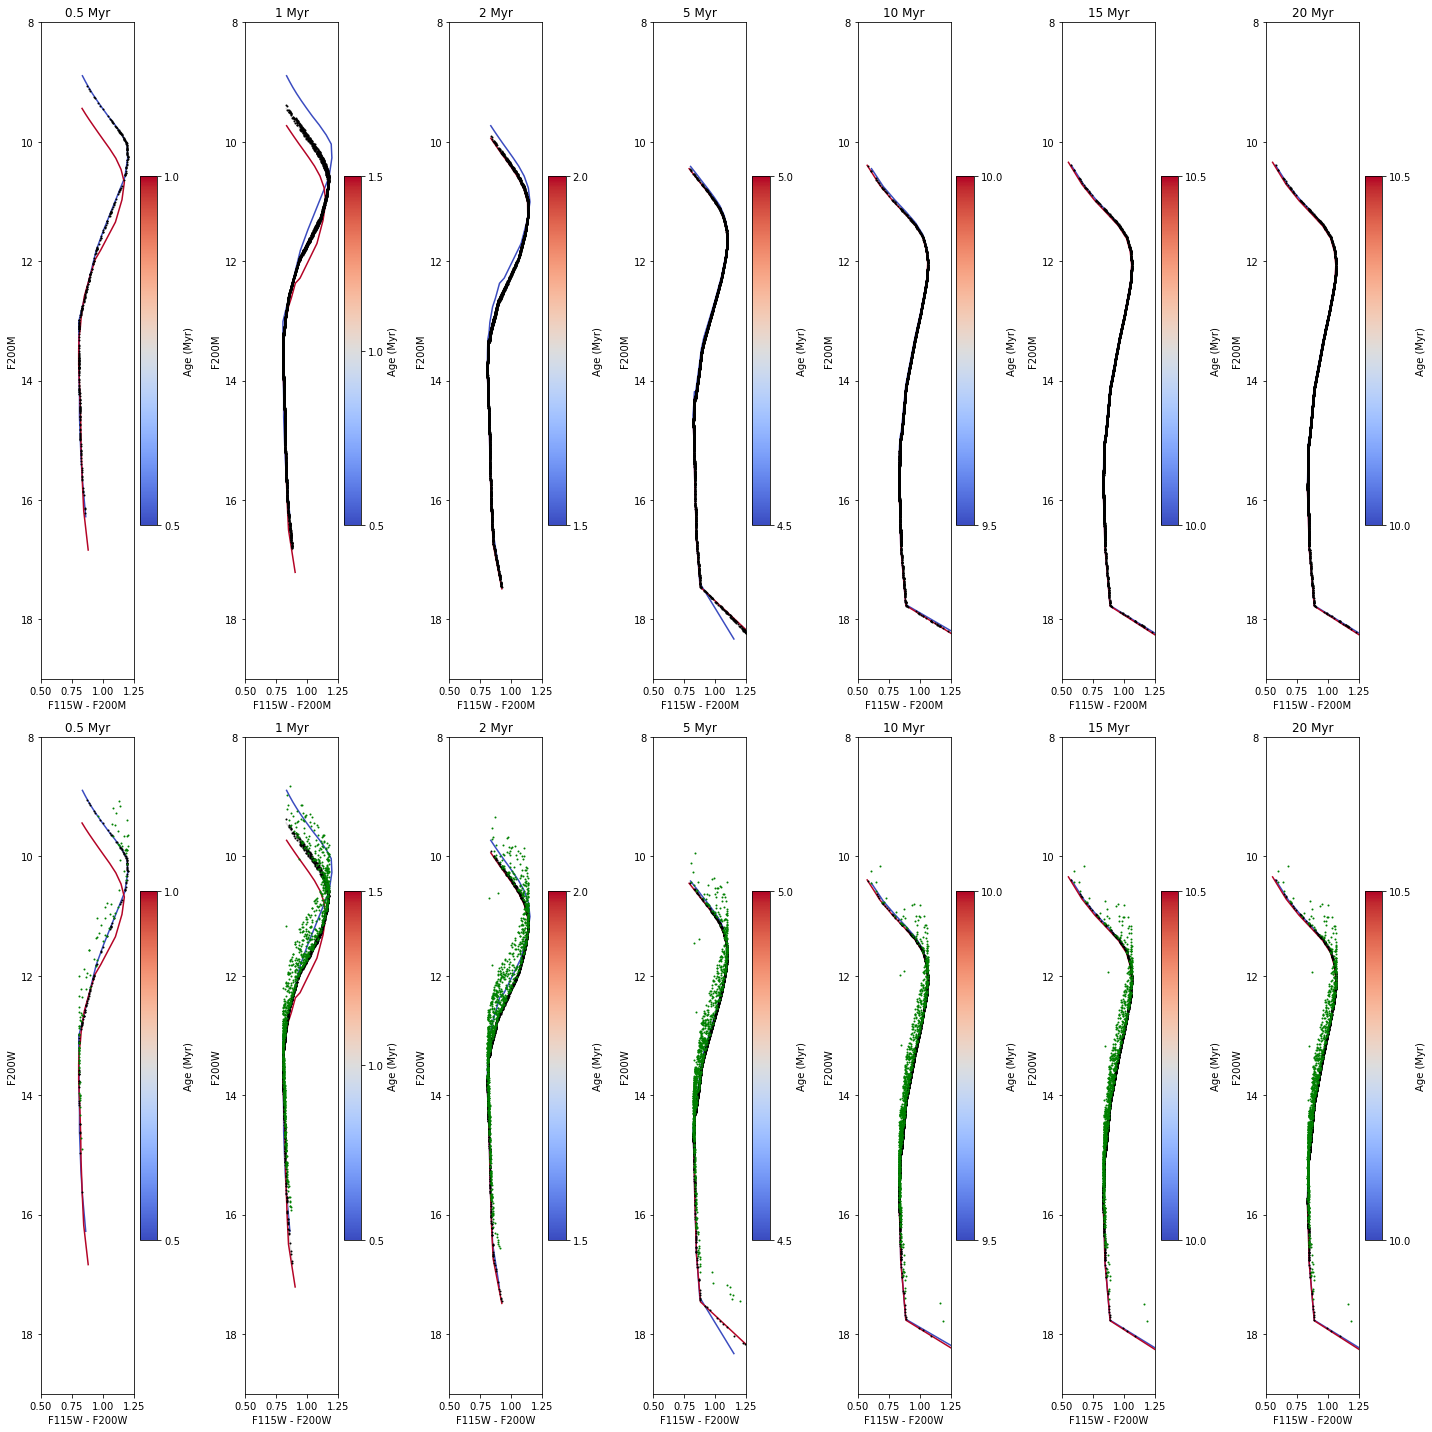

In [24]:
# read nbody data
path_to_data = '../../../../../../../storage/jfarias/Data/Orion/newbinaries/M3000sigma1.0/sfeff030_00/'

fig, axes = py.subplots(figsize=(20, 20))

cluster_times = [0.5, 1, 2, 5, 10, 15, 20]

for t in range(len(cluster_times)):
    # =============== READ NBODY SNAPSHOT =============================
    snapshot = Reader.read_snapshot(path_to_data, time = cluster_times[t])

    # convert snapshot values from nbody units to astrophysical, extract masses
    snapshot.to_physical()
    cluster_table = converter.to_spicea_table(snapshot)
    
    # =============== READ MASS AND AGE ==================================
    masses = cluster_table['mass']
    level_ages = cluster_table['age']

    # convert level ages from Myr to yr
    for i in range(len(level_ages)):
        level_ages[i] = level_ages[i] * 1e6

    # convert log ages from log(Myr) to log(yr)
    log_ages = np.log10(level_ages)
    
    # =============== READ COMPANION STARS ================================
    # find index of first binary, create array of companion masses
    first_binary = 0
    for i in range(len(cluster_table)):
        if cluster_table['isMultiple'][i] == 1.0:
            first_binary = i
            break

    compMasses = []
    for i in range(len(cluster_table)):
        if cluster_table['isMultiple'][i] == 1.0:
            compMasses.append(cluster_table['compMass'][i][0])
            
    # ============== CREATE ISOCHRONE AGE ARRAY ============================
    increment = 0.5e6

    if min(level_ages) < 0.5e6:
        start = 0.5e6
    else:
        start = (min(level_ages) // increment) * increment

    end = (max(level_ages) // increment) * increment + 2 * increment

    # Create age arrays
    level_age_arr = np.arange(start, end, increment)
    log_age_arr = np.log10(level_age_arr)
    
    # ============= CREATE ISOCHRONES =======================================
    instances = np.empty(len(log_age_arr), dtype=object)

    for i in range(len(log_age_arr)):
        my_iso = synthetic.IsochronePhot(log_age_arr[i], AKs, dist, metallicity=metallicity,
                            evo_model=evo_model, atm_func=atm_func,
                            red_law=red_law, filters=filt_list,
                                iso_dir=iso_dir)
        instances[i] = my_iso
        
    # ============= INTERPOLATE STARS =======================================
    import sys
    sys.path.append('/scratch/wyz5rge/synthetic-hr/')
    import interpolator as interpolator

    level_ages_myr = level_ages / 1e6
    # print(level_ages_myr)

    # create array of stars
    stars = np.empty(len(cluster_table), dtype=object)

    # perform interpolation for each star
    for i in range(len(stars)):
        stars[i] = interpolator.interpolate(level_ages_myr[i], masses[i], instances, log_age_arr, filters)
    
    # convert luminosity values to solar luminosities
    watts_to_lsun = 1.0 / (3.846e26)

    for i in range(len(stars)):
        if stars[i] is None:
            continue
        stars[i][0] = stars[i][0] * watts_to_lsun
        
    # perform interpolation on companion stars
    companions = np.empty(len(compMasses), dtype=object)

    for i in range(len(companions)):
        if stars[i + first_binary] is None:
            continue
        companions[i] = interpolator.interpolate(level_ages_myr[i + first_binary], compMasses[i], instances, log_age_arr, filters)

    for i in range(len(companions)):
        if companions[i] is None:
            continue
        companions[i][0] = companions[i][0] * watts_to_lsun
        
    # ============ PLOT RESOLVED BINARIES ===========================

    py.subplot(2, len(cluster_times), t + 1)

    # plot isochrones
    # Define a colormap
    cmap = plt.get_cmap('coolwarm')  # You can choose any colormap you prefer

    for i in range(len(log_age_arr)):
        color = cmap(i / (len(log_age_arr) - 1))  # Assign color based on index and colormap
        py.plot(instances[i].points[filters[0]] - instances[i].points[filters[1]], 
                instances[i].points[filters[1]], color=color, label='')

    # plot primaries
    for i in range(len(stars)):
        if stars[i] is None:
            continue
        py.plot(stars[i][3] - stars[i][4], stars[i][4], marker='o', markersize=1, color='k')

    # plot companions
    for i in range(len(companions)):
        if companions[i] is None:
            continue
        py.plot(companions[i][3] - companions[i][4], companions[i][4], marker='o', markersize=1, color='k')

    py.xlim(xlim_min, xlim_max)
    py.ylim(ylim_min, ylim_max)
    py.xlabel('F115W - F200M')
    py.ylabel('F200M')
    py.gca().invert_yaxis()
    py.title(str(cluster_times[t]) + ' Myr')
    
    # Create colorbar legend
    norm = Normalize(vmin=min(level_age_arr), vmax=max(level_age_arr))
    sm = ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])
    cbar = plt.colorbar(sm)
    cbar.set_label('Age (Myr)')
    cbar.set_ticks(level_age_arr)
    cbar.set_ticklabels([f'{age/1e6:.1f}' for age in level_age_arr])
    
    # Measure spread for resolved binaries
    avg_std_resolved = measure_spread(stars, companions, color_min, color_max, mag_min, mag_max, color_step)
    
    # =========== CALCULATE UNRESOLVED BINARIES ===================
    unresolved_binaries = np.empty(len(companions), dtype=object)

    for i in range(len(companions)):
        if stars[i + first_binary] is None or companions[i] is None:
            continue

        flux11 = np.power(10, stars[i + first_binary][3] / -2.5) * 3.93e-10
        flux21 = np.power(10, companions[i][3] / -2.5) * 3.93e-10
        mag1 = -2.5 * np.log10((flux11 + flux21) / 3.93e-10)

        flux12 = np.power(10, stars[i + first_binary][4] / -2.5) * 5.74e-11
        flux22 = np.power(10, companions[i][4] / -2.5) * 5.74e-11
        mag2 = -2.5 * np.log10((flux12 + flux22) / 5.744e-11)

        unresolved_binaries[i] = [mag1, mag2]
    
    # =========== PLOT UNRESOLVED BINARIES ========================
    
    py.subplot(2, len(cluster_times), t + len(cluster_times) + 1)
    
    for i in range(len(log_age_arr)):
        color = cmap(i / (len(log_age_arr) - 1))  # Assign color based on index and colormap
        py.plot(instances[i].points[filters[0]] - instances[i].points[filters[1]], 
                instances[i].points[filters[1]], color=color, label='')

    # plot single stars first
    for i in range(0, first_binary):
        if stars[i] is None:
            continue
        py.plot(stars[i][3] - stars[i][4], stars[i][4], marker='o', markersize=1, color='k')

    # plot unresolve binaries
    for i in range(len(unresolved_binaries)):
        if unresolved_binaries[i] is None:
            continue
        py.plot(stars[first_binary + i][3] - stars[first_binary + i][4], 
                unresolved_binaries[i][1], marker='o', markersize=1, color='green')

    py.xlim(xlim_min, xlim_max)
    py.ylim(ylim_min, ylim_max)
    py.xlabel('F115W - F200W')
    py.ylabel('F200W')
    py.gca().invert_yaxis()
    py.title(str(cluster_times[t]) + ' Myr')
    
    # Create colorbar legend
    norm = Normalize(vmin=min(level_age_arr), vmax=max(level_age_arr))
    sm = ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])
    cbar = plt.colorbar(sm)
    cbar.set_label('Age (Myr)')
    cbar.set_ticks(level_age_arr)
    cbar.set_ticklabels([f'{age/1e6:.1f}' for age in level_age_arr])
    
    # Measure spread for unresolved binaries
    avg_std_unresolved = measure_spread_unresolved(stars[:first_binary], unresolved_binaries, color_min, color_max, mag_min, mag_max, color_step)
    
    # ========== PRINT SPREAD RESULTS ===========================
    print(f"Cluster Time: {cluster_times[t]} Myr")
    print(f"Average Standard Deviation (Resolved): {avg_std_resolved:.2f}")
    print(f"Average Standard Deviation (Unresolved): {avg_std_unresolved:.2f}")
    print()
    
plt.tight_layout()
plt.show()

Cluster Time: 0.5 Myr
Average Standard Deviation (Resolved): 0.02
Average Standard Deviation (Unresolved): 0.14

Cluster Time: 1 Myr
Average Standard Deviation (Resolved): 0.01
Average Standard Deviation (Unresolved): 0.23

Cluster Time: 2 Myr
Average Standard Deviation (Resolved): 0.01
Average Standard Deviation (Unresolved): 0.27

Cluster Time: 5 Myr
Average Standard Deviation (Resolved): 0.06
Average Standard Deviation (Unresolved): 0.30

Cluster Time: 10 Myr
Average Standard Deviation (Resolved): 0.47
Average Standard Deviation (Unresolved): 0.52

Cluster Time: 15 Myr
Average Standard Deviation (Resolved): 0.35
Average Standard Deviation (Unresolved): 0.47

Cluster Time: 20 Myr
Average Standard Deviation (Resolved): 0.38
Average Standard Deviation (Unresolved): 0.47



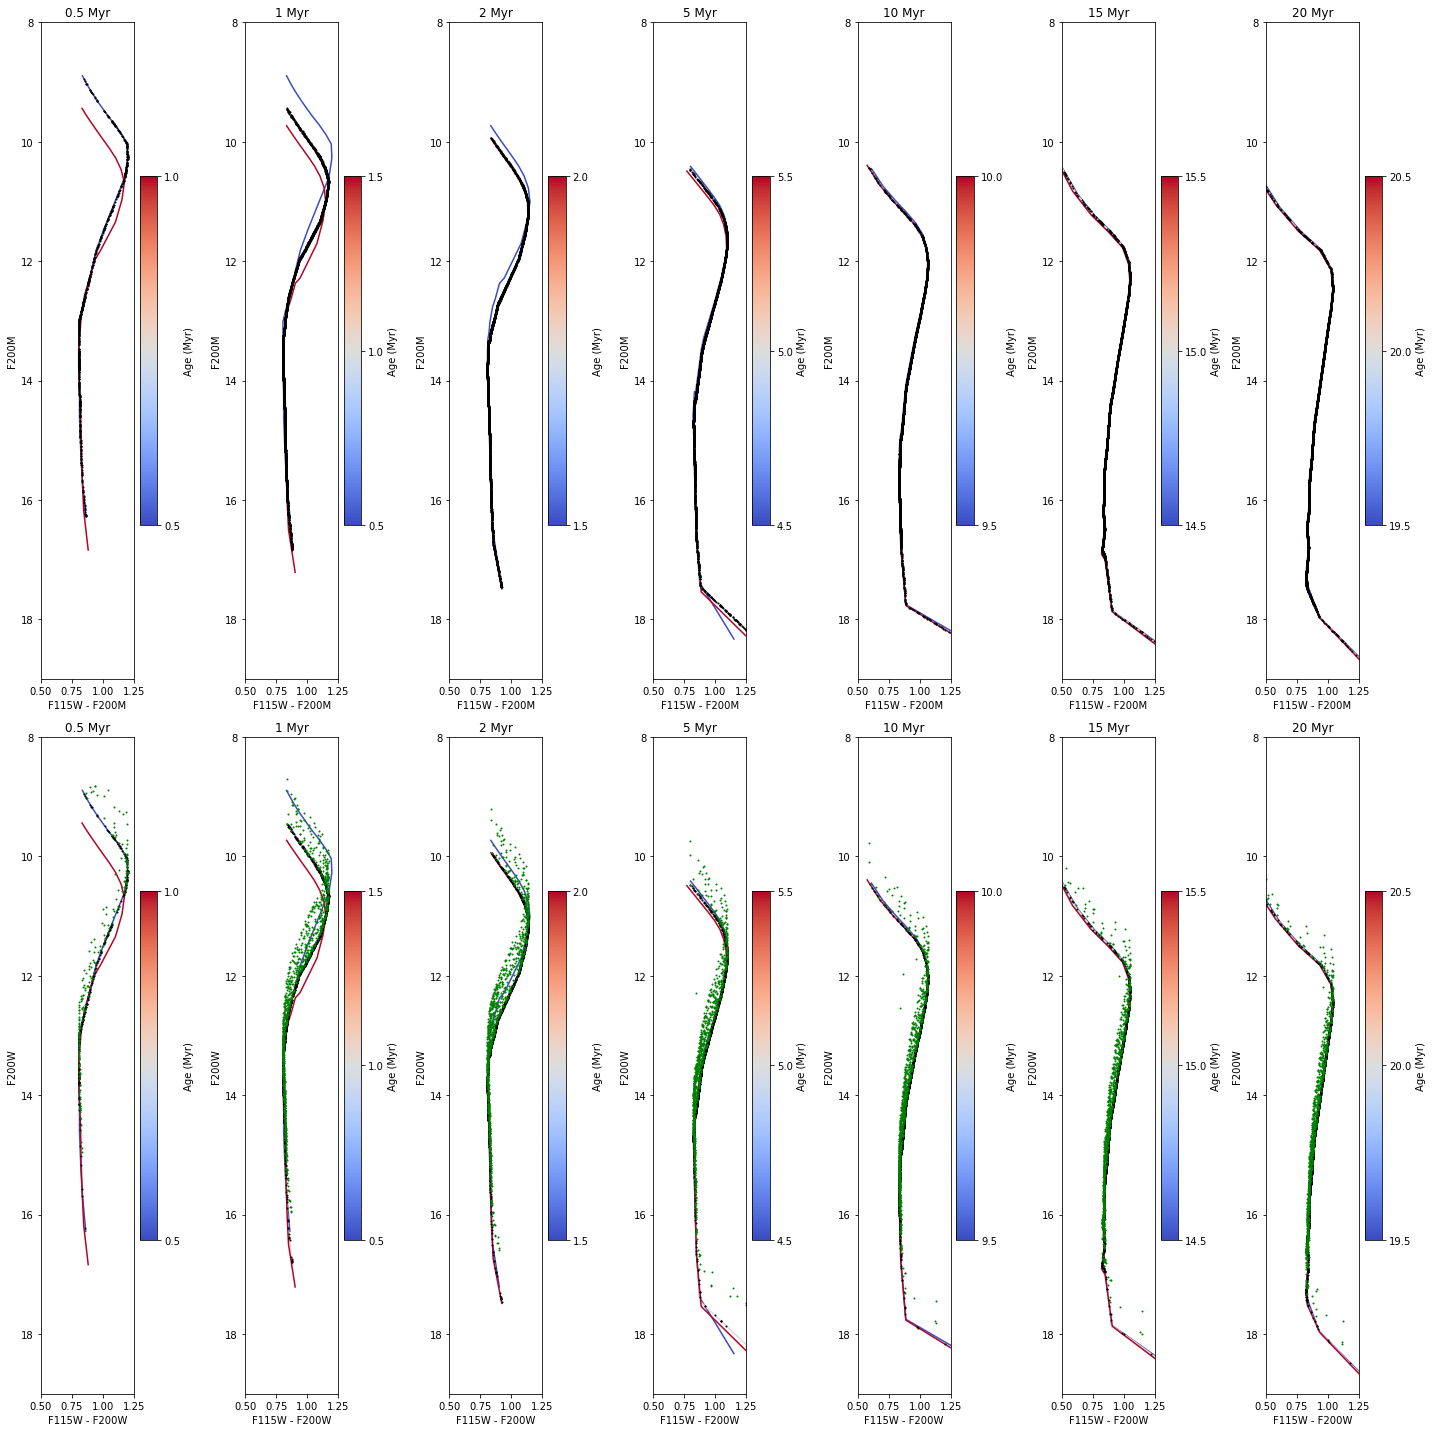

In [25]:
# read nbody data
path_to_data = '../../../../../../../storage/jfarias/Data/Orion/newbinaries/M3000sigma1.0/sfeff100_00/'

fig, axes = py.subplots(figsize=(20, 20))

cluster_times = [0.5, 1, 2, 5, 10, 15, 20]

for t in range(len(cluster_times)):
    # =============== READ NBODY SNAPSHOT =============================
    snapshot = Reader.read_snapshot(path_to_data, time = cluster_times[t])

    # convert snapshot values from nbody units to astrophysical, extract masses
    snapshot.to_physical()
    cluster_table = converter.to_spicea_table(snapshot)
    
    # =============== READ MASS AND AGE ==================================
    masses = cluster_table['mass']
    level_ages = cluster_table['age']

    # convert level ages from Myr to yr
    for i in range(len(level_ages)):
        level_ages[i] = level_ages[i] * 1e6

    # convert log ages from log(Myr) to log(yr)
    log_ages = np.log10(level_ages)
    
    # =============== READ COMPANION STARS ================================
    # find index of first binary, create array of companion masses
    first_binary = 0
    for i in range(len(cluster_table)):
        if cluster_table['isMultiple'][i] == 1.0:
            first_binary = i
            break

    compMasses = []
    for i in range(len(cluster_table)):
        if cluster_table['isMultiple'][i] == 1.0:
            compMasses.append(cluster_table['compMass'][i][0])
            
    # ============== CREATE ISOCHRONE AGE ARRAY ============================
    increment = 0.5e6

    if min(level_ages) < 0.5e6:
        start = 0.5e6
    else:
        start = (min(level_ages) // increment) * increment

    end = (max(level_ages) // increment) * increment + 2 * increment

    # Create age arrays
    level_age_arr = np.arange(start, end, increment)
    log_age_arr = np.log10(level_age_arr)
    
    # ============= CREATE ISOCHRONES =======================================
    instances = np.empty(len(log_age_arr), dtype=object)

    for i in range(len(log_age_arr)):
        my_iso = synthetic.IsochronePhot(log_age_arr[i], AKs, dist, metallicity=metallicity,
                            evo_model=evo_model, atm_func=atm_func,
                            red_law=red_law, filters=filt_list,
                                iso_dir=iso_dir)
        instances[i] = my_iso
        
    # ============= INTERPOLATE STARS =======================================
    import sys
    sys.path.append('/scratch/wyz5rge/synthetic-hr/')
    import interpolator as interpolator

    level_ages_myr = level_ages / 1e6
    # print(level_ages_myr)

    # create array of stars
    stars = np.empty(len(cluster_table), dtype=object)

    # perform interpolation for each star
    for i in range(len(stars)):
        stars[i] = interpolator.interpolate(level_ages_myr[i], masses[i], instances, log_age_arr, filters)
    
    # convert luminosity values to solar luminosities
    watts_to_lsun = 1.0 / (3.846e26)

    for i in range(len(stars)):
        if stars[i] is None:
            continue
        stars[i][0] = stars[i][0] * watts_to_lsun
        
    # perform interpolation on companion stars
    companions = np.empty(len(compMasses), dtype=object)

    for i in range(len(companions)):
        if stars[i + first_binary] is None:
            continue
        companions[i] = interpolator.interpolate(level_ages_myr[i + first_binary], compMasses[i], instances, log_age_arr, filters)

    for i in range(len(companions)):
        if companions[i] is None:
            continue
        companions[i][0] = companions[i][0] * watts_to_lsun
        
    # ============ PLOT RESOLVED BINARIES ===========================

    py.subplot(2, len(cluster_times), t + 1)

    # plot isochrones
    # Define a colormap
    cmap = plt.get_cmap('coolwarm')  # You can choose any colormap you prefer

    for i in range(len(log_age_arr)):
        color = cmap(i / (len(log_age_arr) - 1))  # Assign color based on index and colormap
        py.plot(instances[i].points[filters[0]] - instances[i].points[filters[1]], 
                instances[i].points[filters[1]], color=color, label='')

    # plot primaries
    for i in range(len(stars)):
        if stars[i] is None:
            continue
        py.plot(stars[i][3] - stars[i][4], stars[i][4], marker='o', markersize=1, color='k')

    # plot companions
    for i in range(len(companions)):
        if companions[i] is None:
            continue
        py.plot(companions[i][3] - companions[i][4], companions[i][4], marker='o', markersize=1, color='k')

    py.xlim(xlim_min, xlim_max)
    py.ylim(ylim_min, ylim_max)
    py.xlabel('F115W - F200M')
    py.ylabel('F200M')
    py.gca().invert_yaxis()
    py.title(str(cluster_times[t]) + ' Myr')
    
    # Create colorbar legend
    norm = Normalize(vmin=min(level_age_arr), vmax=max(level_age_arr))
    sm = ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])
    cbar = plt.colorbar(sm)
    cbar.set_label('Age (Myr)')
    cbar.set_ticks(level_age_arr)
    cbar.set_ticklabels([f'{age/1e6:.1f}' for age in level_age_arr])
    
    # Measure spread for resolved binaries
    avg_std_resolved = measure_spread(stars, companions, color_min, color_max, mag_min, mag_max, color_step)
    
    # =========== CALCULATE UNRESOLVED BINARIES ===================
    unresolved_binaries = np.empty(len(companions), dtype=object)

    for i in range(len(companions)):
        if stars[i + first_binary] is None or companions[i] is None:
            continue

        flux11 = np.power(10, stars[i + first_binary][3] / -2.5) * 3.93e-10
        flux21 = np.power(10, companions[i][3] / -2.5) * 3.93e-10
        mag1 = -2.5 * np.log10((flux11 + flux21) / 3.93e-10)

        flux12 = np.power(10, stars[i + first_binary][4] / -2.5) * 5.74e-11
        flux22 = np.power(10, companions[i][4] / -2.5) * 5.74e-11
        mag2 = -2.5 * np.log10((flux12 + flux22) / 5.744e-11)

        unresolved_binaries[i] = [mag1, mag2]
    
    # =========== PLOT UNRESOLVED BINARIES ========================
    
    py.subplot(2, len(cluster_times), t + len(cluster_times) + 1)
    
    for i in range(len(log_age_arr)):
        color = cmap(i / (len(log_age_arr) - 1))  # Assign color based on index and colormap
        py.plot(instances[i].points[filters[0]] - instances[i].points[filters[1]], 
                instances[i].points[filters[1]], color=color, label='')

    # plot single stars first
    for i in range(0, first_binary):
        if stars[i] is None:
            continue
        py.plot(stars[i][3] - stars[i][4], stars[i][4], marker='o', markersize=1, color='k')

    # plot unresolve binaries
    for i in range(len(unresolved_binaries)):
        if unresolved_binaries[i] is None:
            continue
        py.plot(stars[first_binary + i][3] - stars[first_binary + i][4], 
                unresolved_binaries[i][1], marker='o', markersize=1, color='green')

    py.xlim(xlim_min, xlim_max)
    py.ylim(ylim_min, ylim_max)
    py.xlabel('F115W - F200W')
    py.ylabel('F200W')
    py.gca().invert_yaxis()
    py.title(str(cluster_times[t]) + ' Myr')
    
    # Create colorbar legend
    norm = Normalize(vmin=min(level_age_arr), vmax=max(level_age_arr))
    sm = ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])
    cbar = plt.colorbar(sm)
    cbar.set_label('Age (Myr)')
    cbar.set_ticks(level_age_arr)
    cbar.set_ticklabels([f'{age/1e6:.1f}' for age in level_age_arr])
    
    # Measure spread for unresolved binaries
    avg_std_unresolved = measure_spread_unresolved(stars[:first_binary], unresolved_binaries, color_min, color_max, mag_min, mag_max, color_step)
    
    # ========== PRINT SPREAD RESULTS ===========================
    print(f"Cluster Time: {cluster_times[t]} Myr")
    print(f"Average Standard Deviation (Resolved): {avg_std_resolved:.2f}")
    print(f"Average Standard Deviation (Unresolved): {avg_std_unresolved:.2f}")
    print()
    
plt.tight_layout()
plt.show()

Cluster Time: 0.5 Myr
Average Standard Deviation (Resolved): 0.02
Average Standard Deviation (Unresolved): 0.21

Cluster Time: 1 Myr
Average Standard Deviation (Resolved): 0.01
Average Standard Deviation (Unresolved): 0.23

Cluster Time: 2 Myr
Average Standard Deviation (Resolved): 0.01
Average Standard Deviation (Unresolved): 0.23

Cluster Time: 5 Myr
Average Standard Deviation (Resolved): 0.08
Average Standard Deviation (Unresolved): 0.27

Cluster Time: 10 Myr
Average Standard Deviation (Resolved): 0.44
Average Standard Deviation (Unresolved): 0.47

Cluster Time: 15 Myr
Average Standard Deviation (Resolved): 0.38
Average Standard Deviation (Unresolved): 0.45

Cluster Time: 20 Myr
Average Standard Deviation (Resolved): 0.28
Average Standard Deviation (Unresolved): 0.38



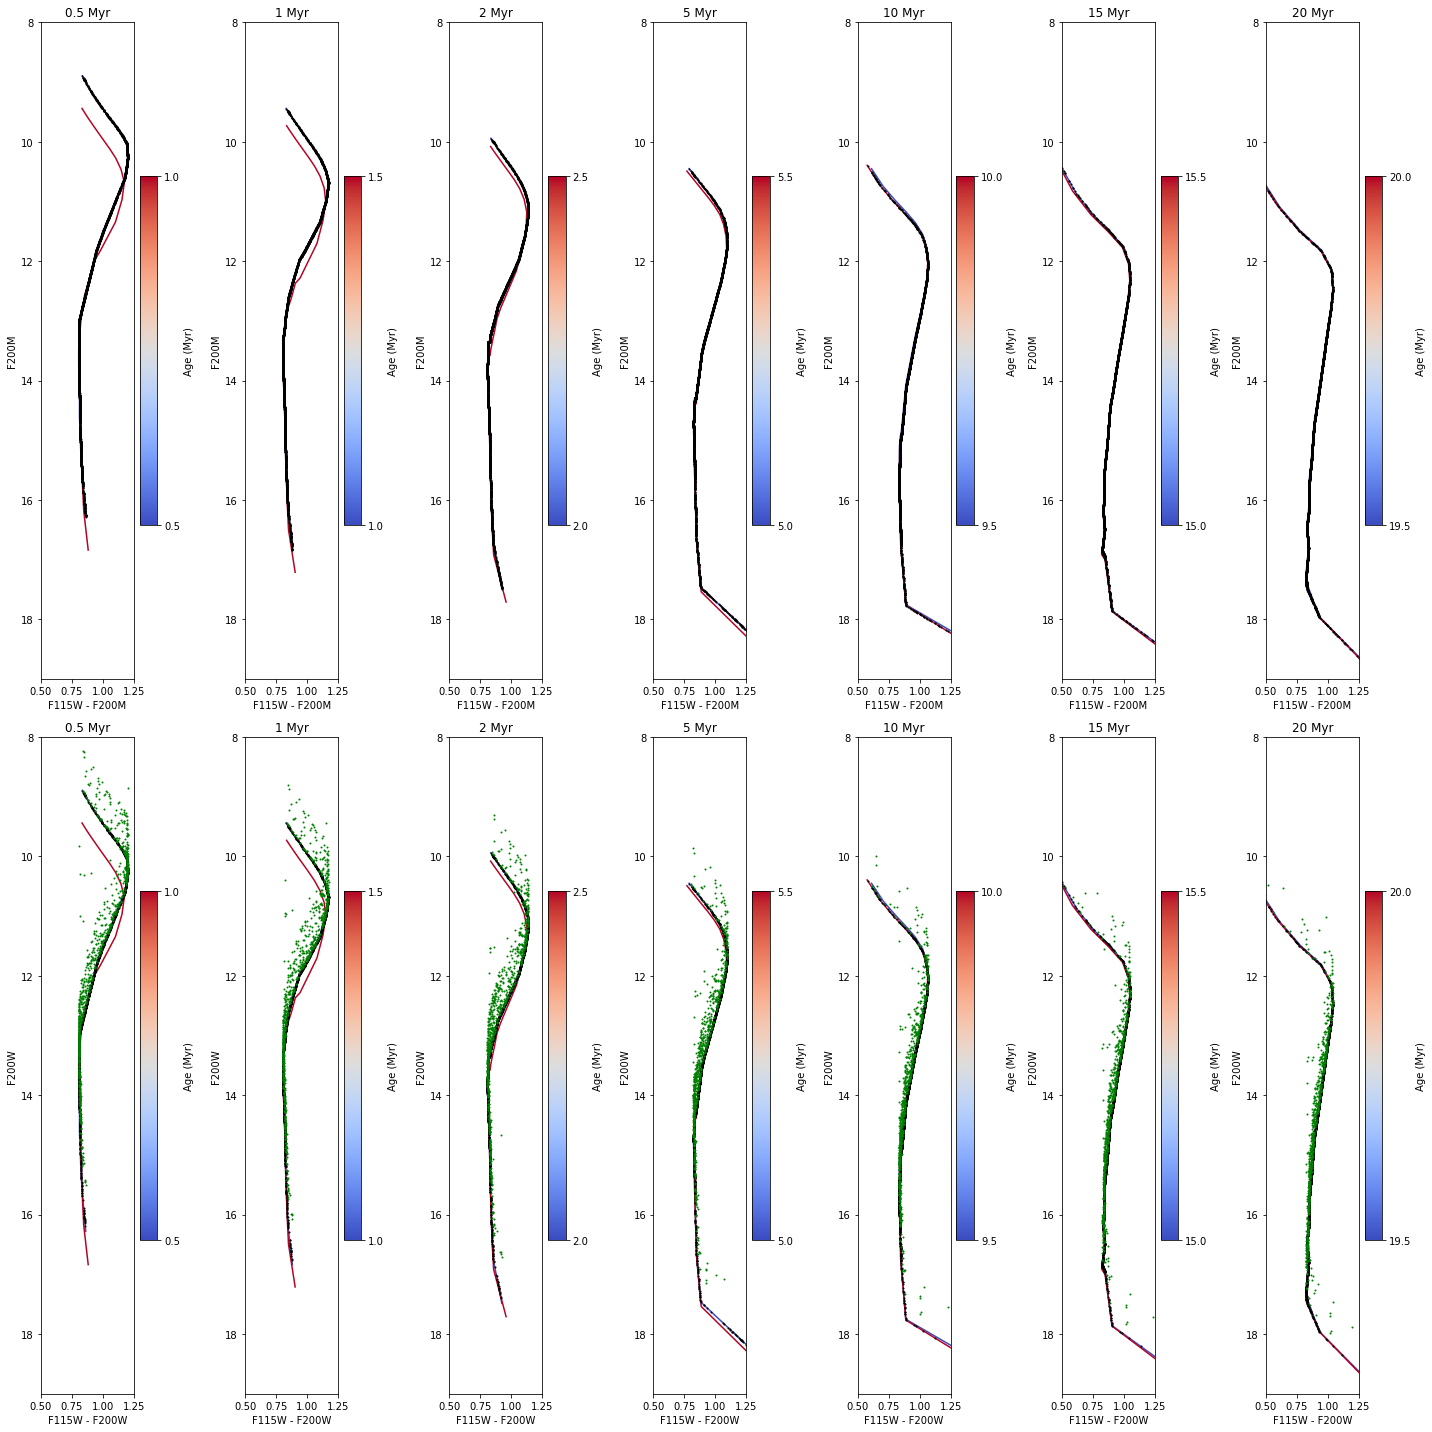

In [26]:
# read nbody data
path_to_data = '../../../../../../../storage/jfarias/runningM3000/M3000sigma1.0/sfeff-100_00/'

fig, axes = py.subplots(figsize=(20, 20))

cluster_times = [0.5, 1, 2, 5, 10, 15, 20]

for t in range(len(cluster_times)):
    # =============== READ NBODY SNAPSHOT =============================
    snapshot = Reader.read_snapshot(path_to_data, time = cluster_times[t])

    # convert snapshot values from nbody units to astrophysical, extract masses
    snapshot.to_physical()
    cluster_table = converter.to_spicea_table(snapshot)
    
    # =============== READ MASS AND AGE ==================================
    masses = cluster_table['mass']
    level_ages = cluster_table['age']

    # convert level ages from Myr to yr
    for i in range(len(level_ages)):
        level_ages[i] = level_ages[i] * 1e6

    # convert log ages from log(Myr) to log(yr)
    log_ages = np.log10(level_ages)
    
    # =============== READ COMPANION STARS ================================
    # find index of first binary, create array of companion masses
    first_binary = 0
    for i in range(len(cluster_table)):
        if cluster_table['isMultiple'][i] == 1.0:
            first_binary = i
            break

    compMasses = []
    for i in range(len(cluster_table)):
        if cluster_table['isMultiple'][i] == 1.0:
            compMasses.append(cluster_table['compMass'][i][0])
            
    # ============== CREATE ISOCHRONE AGE ARRAY ============================
    increment = 0.5e6

    if min(level_ages) < 0.5e6:
        start = 0.5e6
    else:
        start = (min(level_ages) // increment) * increment

    end = (max(level_ages) // increment) * increment + 2 * increment

    # Create age arrays
    level_age_arr = np.arange(start, end, increment)
    log_age_arr = np.log10(level_age_arr)
    
    # ============= CREATE ISOCHRONES =======================================
    instances = np.empty(len(log_age_arr), dtype=object)

    for i in range(len(log_age_arr)):
        my_iso = synthetic.IsochronePhot(log_age_arr[i], AKs, dist, metallicity=metallicity,
                            evo_model=evo_model, atm_func=atm_func,
                            red_law=red_law, filters=filt_list,
                                iso_dir=iso_dir)
        instances[i] = my_iso
        
    # ============= INTERPOLATE STARS =======================================
    import sys
    sys.path.append('/scratch/wyz5rge/synthetic-hr/')
    import interpolator as interpolator

    level_ages_myr = level_ages / 1e6
    # print(level_ages_myr)

    # create array of stars
    stars = np.empty(len(cluster_table), dtype=object)

    # perform interpolation for each star
    for i in range(len(stars)):
        stars[i] = interpolator.interpolate(level_ages_myr[i], masses[i], instances, log_age_arr, filters)
    
    # convert luminosity values to solar luminosities
    watts_to_lsun = 1.0 / (3.846e26)

    for i in range(len(stars)):
        if stars[i] is None:
            continue
        stars[i][0] = stars[i][0] * watts_to_lsun
        
    # perform interpolation on companion stars
    companions = np.empty(len(compMasses), dtype=object)

    for i in range(len(companions)):
        if stars[i + first_binary] is None:
            continue
        companions[i] = interpolator.interpolate(level_ages_myr[i + first_binary], compMasses[i], instances, log_age_arr, filters)

    for i in range(len(companions)):
        if companions[i] is None:
            continue
        companions[i][0] = companions[i][0] * watts_to_lsun
        
    # ============ PLOT RESOLVED BINARIES ===========================

    py.subplot(2, len(cluster_times), t + 1)

    # plot isochrones
    # Define a colormap
    cmap = plt.get_cmap('coolwarm')  # You can choose any colormap you prefer

    for i in range(len(log_age_arr)):
        color = cmap(i / (len(log_age_arr) - 1))  # Assign color based on index and colormap
        py.plot(instances[i].points[filters[0]] - instances[i].points[filters[1]], 
                instances[i].points[filters[1]], color=color, label='')

    # plot primaries
    for i in range(len(stars)):
        if stars[i] is None:
            continue
        py.plot(stars[i][3] - stars[i][4], stars[i][4], marker='o', markersize=1, color='k')

    # plot companions
    for i in range(len(companions)):
        if companions[i] is None:
            continue
        py.plot(companions[i][3] - companions[i][4], companions[i][4], marker='o', markersize=1, color='k')

    py.xlim(xlim_min, xlim_max)
    py.ylim(ylim_min, ylim_max)
    py.xlabel('F115W - F200M')
    py.ylabel('F200M')
    py.gca().invert_yaxis()
    py.title(str(cluster_times[t]) + ' Myr')
    
    # Create colorbar legend
    norm = Normalize(vmin=min(level_age_arr), vmax=max(level_age_arr))
    sm = ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])
    cbar = plt.colorbar(sm)
    cbar.set_label('Age (Myr)')
    cbar.set_ticks(level_age_arr)
    cbar.set_ticklabels([f'{age/1e6:.1f}' for age in level_age_arr])
    
    # Measure spread for resolved binaries
    avg_std_resolved = measure_spread(stars, companions, color_min, color_max, mag_min, mag_max, color_step)
    
    # =========== CALCULATE UNRESOLVED BINARIES ===================
    unresolved_binaries = np.empty(len(companions), dtype=object)

    for i in range(len(companions)):
        if stars[i + first_binary] is None or companions[i] is None:
            continue

        flux11 = np.power(10, stars[i + first_binary][3] / -2.5) * 3.93e-10
        flux21 = np.power(10, companions[i][3] / -2.5) * 3.93e-10
        mag1 = -2.5 * np.log10((flux11 + flux21) / 3.93e-10)

        flux12 = np.power(10, stars[i + first_binary][4] / -2.5) * 5.74e-11
        flux22 = np.power(10, companions[i][4] / -2.5) * 5.74e-11
        mag2 = -2.5 * np.log10((flux12 + flux22) / 5.744e-11)

        unresolved_binaries[i] = [mag1, mag2]
    
    # =========== PLOT UNRESOLVED BINARIES ========================
    
    py.subplot(2, len(cluster_times), t + len(cluster_times) + 1)
    
    for i in range(len(log_age_arr)):
        color = cmap(i / (len(log_age_arr) - 1))  # Assign color based on index and colormap
        py.plot(instances[i].points[filters[0]] - instances[i].points[filters[1]], 
                instances[i].points[filters[1]], color=color, label='')

    # plot single stars first
    for i in range(0, first_binary):
        if stars[i] is None:
            continue
        py.plot(stars[i][3] - stars[i][4], stars[i][4], marker='o', markersize=1, color='k')

    # plot unresolve binaries
    for i in range(len(unresolved_binaries)):
        if unresolved_binaries[i] is None:
            continue
        py.plot(stars[first_binary + i][3] - stars[first_binary + i][4], 
                unresolved_binaries[i][1], marker='o', markersize=1, color='green')

    py.xlim(xlim_min, xlim_max)
    py.ylim(ylim_min, ylim_max)
    py.xlabel('F115W - F200W')
    py.ylabel('F200W')
    py.gca().invert_yaxis()
    py.title(str(cluster_times[t]) + ' Myr')
    
    # Create colorbar legend
    norm = Normalize(vmin=min(level_age_arr), vmax=max(level_age_arr))
    sm = ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])
    cbar = plt.colorbar(sm)
    cbar.set_label('Age (Myr)')
    cbar.set_ticks(level_age_arr)
    cbar.set_ticklabels([f'{age/1e6:.1f}' for age in level_age_arr])
    
    # Measure spread for unresolved binaries
    avg_std_unresolved = measure_spread_unresolved(stars[:first_binary], unresolved_binaries, color_min, color_max, mag_min, mag_max, color_step)
    
    # ========== PRINT SPREAD RESULTS ===========================
    print(f"Cluster Time: {cluster_times[t]} Myr")
    print(f"Average Standard Deviation (Resolved): {avg_std_resolved:.2f}")
    print(f"Average Standard Deviation (Unresolved): {avg_std_unresolved:.2f}")
    print()
    
plt.tight_layout()
plt.show()